<a href="https://colab.research.google.com/github/xiaochengJF/MachineLearning/blob/master/Ex_8_Anomaly_Detection_%26_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/MachineLearning/ex8-anomaly detection and recommendation

/content/drive/My Drive/MachineLearning/ex8-anomaly detection and recommendation


# 1-异常检测

<font face=楷体 color=green size=4>**绿色链接：**</font>  

【1】[covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)  
【2】[multivariate_normal](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html)  
【3】[seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"), color_codes=False)

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split  # cross_validatio包早就不使用，划分到model_selection中

<font face=楷体 color=skyblue size=4>将数据分成三部分：</font>  
<font face=楷体>
* 训练集
* 交叉验证集
* 测试集 
</font> 

In [7]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [0]:
X = mat.get('X')

<font face=楷体>
将原始验证数据划分为验证集和测试集
</font> 

In [0]:
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

 <font face=楷体>
 可视化训练数据
 </font>

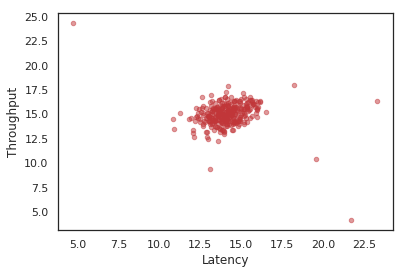

In [10]:
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})
plt.show()

## 估计多元高斯参数$\mu$和$\sigma^2$

 <font face=楷体 color=skyblue>
$X_1$和$X_2$并不独立
</font>

In [11]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)
print(cov)

[14.11222578 14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


 <font face=楷体 color=skyblue>
例：创建二维网格来计算概率密度
</font>

In [12]:
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

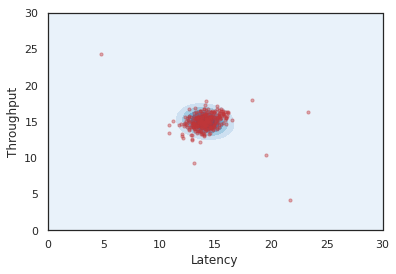

In [13]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})
plt.show()

# 选择阈值 $\epsilon$  
<font face=楷体>
    
* 使用训练集$X$对多元高斯函数建模  
* 使用交叉验证集$(X_{val}, y_{val})$通过找到最佳的“$F-score$”来找到对应的 $\epsilon$  
</font>  

$$\begin{aligned}
&F_1=\frac{2\cdot\ prec\cdot\ rec}{prec+ rec}\\
&prec=\frac{t_p}{t_p+f_p}\\
&rec=\frac{t_p}{t_p+f_n}
\end{aligned}$$

In [0]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]

In [15]:
from sklearn.metrics import f1_score, classification_report

e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.593415376575984e-05
Best F-score on validation data: 0.888888888888889



## 使用学习到的 $\epsilon$ 可视化预测 $X_{val}$  
<font face=楷体>

* 使用CV数据找出最好的 $\epsilon$  
* 使用所有数据(培训+验证)创建模型  
* 对测试数据进行预测
</font>

In [0]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


def predict(X, Xval, e, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred